In [13]:
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm


In [4]:
class LidarBrain(nn.Module):
    
    def __init__(self, inputs_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, outputs_size):
        super().__init__()

        self.lb_model = nn.Sequential(
            nn.Linear(inputs_size, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.ReLU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.ReLU(),
            nn.Linear(hidden5_size, outputs_size)
            # nn.ReLU(),
            # nn.Linear(hidden4_size, outputs_size)
        )

    def forward(self, x):

        return self.lb_model(x)

In [5]:
load_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/data/data_3rounds"

data_file = pd.read_table(load_path, sep = ",", index_col = 0)


# Create X data and Y data by converting them to torch.tensor
X = torch.Tensor(np.array(data_file.iloc[:, :-2], copy=False))

# We decided to leave out the velocity for now.
Y = torch.Tensor(np.array(data_file.iloc[:, 16:17], copy=False))

print(X)
print(Y[0].type())
print(data_file.head())

tensor([[ 7.4593,  6.8660,  8.4048,  ...,  4.3179,  5.5356,  1.4650],
        [ 7.4592,  6.8659,  8.4047,  ...,  4.3179,  5.5356,  1.4650],
        [ 7.4592,  6.8659,  8.4047,  ...,  4.3179,  5.5356,  1.4650],
        ...,
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000],
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000],
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000]])
torch.FloatTensor
        0       1       2        3        4        5       6       7        8  \
0  7.4593  6.8660  8.4048  10.2781  12.9475   9.7540  5.7571  5.8859   3.9555   
1  7.4592  6.8659  8.4047  10.2780  12.9474   9.7540  5.7570  5.8859   3.9554   
2  7.4592  6.8659  8.4047  10.2780  12.9474   9.7540  5.7570  5.8859   3.9554   
3  7.4566  6.8634  8.4025  10.2759  12.9456  11.2519  5.7557  5.8850  20.0000   
4  7.4507  6.8577  8.3973  10.2711  12.9414  11.2484  5.7526  5.8828  20.0000   

      9    10      11      12      13      14      15    16  

LidarBrain(
  (lb_model): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
)


100%|██████████| 200/200 [01:35<00:00,  2.10it/s]

[173.64642634496064, 127.24428965225371, 110.43625428899382, 103.8925773372233, 98.45846812815125, 93.89541223461538, 89.1555653471596, 86.04071189300204, 80.76411287922035, 78.1962252497436, 74.77000643386992, 71.85120866597292, 68.93954124460163, 64.87345556046806, 62.37820013190358, 59.43649350909542, 57.529937468276586, 52.9990024941105, 49.17179039173998, 46.173659013706455, 45.38027741089019, 41.100961014006295, 38.43385525583984, 34.99556374834262, 32.005302139589375, 31.765526923697227, 29.290849958215034, 27.653322682939987, 24.88312677929463, 23.633022502212828, 22.927487136592447, 19.189107459297713, 20.27094742033638, 16.93581903217801, 16.800099830267207, 14.233843320999183, 14.398249603763489, 13.899927971140292, 12.47094230398269, 11.566981940691324, 11.877109745980258, 10.010176915416187, 9.45471511659755, 9.1449243978525, 8.416488854003473, 7.960044922044216, 8.228623732302346, 8.176268821978427, 6.66969425967389, 6.509315826250592, 6.866304489774685, 6.695535634372153

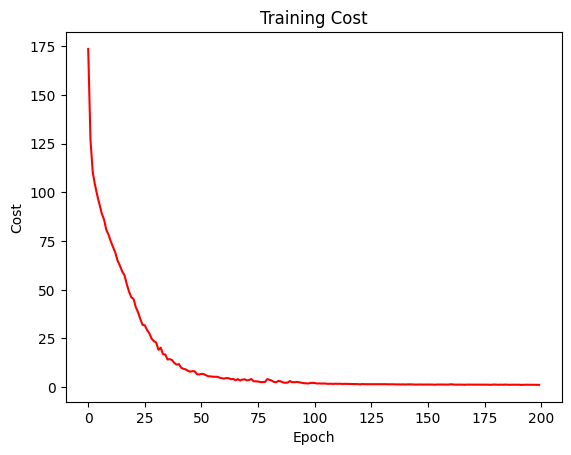

In [33]:
epochs = 200

learningRate = 0.000095

#----------------------------------------

lb = LidarBrain(len(X[0]), 128, 128, 128, 128, 128, len(Y[0]))

print(lb)

#----------------------------------------

losses = []

# Take binary cross entropy as loss function (one output interpreted as binary)
lossFunction = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent = torch.optim.SGD(lb.parameters(), lr=learningRate)

#----------------------------------------

loader = DataLoader(list(zip(X, Y)), shuffle=True, batch_size=10)

for i in tqdm(range(epochs)):

    losses_epoch = []
    for x, y in loader:
    
        # Reset the gradient delta's (dw, db)
        gradientDescent.zero_grad()

        # Forward step
        yhat = lb(x)

        # Compute loss
        loss = lossFunction(yhat, y)
        
        # Keep track of loss
        losses_epoch.append(loss.item())

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent.step()

    losses.append(sum(losses_epoch)/len(losses_epoch))

print(losses)

#----------------------------------------

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(len(losses))], losses, 'red')
plt.show()

#----------------------------------------

In [34]:
save_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/pickle/LidarBrain.pkl"

pickle.dump(lb.lb_model, open(save_path, 'wb'))

## After trying lots and lots of different things my conclusion is that Lidar is to unstable on THIS track to function in a safe way.

Things I've tried:
- Different Epochs
- Different learning rates
- Different data sets
- Different batch sizes
- More/less hiddenlayers
- More/less neurons
- With/without activation function.
- Different max range on the scanner


# Now with Sonar

In [17]:
class SonarBrain(nn.Module):
    
    def __init__(self, inputs_size, hidden1_size, hidden2_size, outputs_size):
        super().__init__()

        self.sb_model = nn.Sequential(
            nn.Linear(inputs_size, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, outputs_size)
            # nn.ReLU(),
            # nn.Linear(hidden3_size, outputs_size)
            # nn.Linear(hidden2_size, hidden3_size),
            # nn.ReLU(),
            # nn.Linear(hidden3_size, hidden4_size),
            # nn.ReLU(),
            # nn.Linear(hidden4_size, outputs_size)
        )

    def forward(self, x):

        return self.sb_model(x)

In [6]:
load_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/data/sonar_data_3r"

data_file_2 = pd.read_table(load_path, sep = ",", index_col = 0)


# Create X data and Y data by converting them to torch.tensor
X_2 = torch.Tensor(np.array(data_file_2.iloc[:, :-2], copy=False))

# We decided to leave out the velocity for now.
Y_2 = torch.Tensor(np.array(data_file_2.iloc[:, 3:4], copy=False))

print(X_2)
print(Y_2)
print(data_file_2.head())

tensor([[1.4683, 1.2854, 1.7757],
        [1.4683, 1.2854, 1.7757],
        [1.4683, 1.2854, 1.7757],
        ...,
        [2.0547, 1.3089, 0.9240],
        [2.0547, 1.3089, 0.9240],
        [1.9351, 1.2385, 1.3189]])
tensor([[-22.],
        [-22.],
        [-22.],
        ...,
        [  0.],
        [  0.],
        [  0.]])
        0       1       2     3         4
0  1.4683  1.2854  1.7757 -22.0  1.133333
1  1.4683  1.2854  1.7757 -22.0  1.133333
2  1.4683  1.2854  1.7757 -22.0  1.133333
3  1.4683  1.2854  1.7757 -22.0  1.133333
4  1.4683  1.2854  1.7757 -22.0  1.133333


SonarBrain(
  (sb_model): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


100%|██████████| 100/100 [02:38<00:00,  1.59s/it]

[101.08351703035446, 93.30143506276922, 89.23353503242498, 84.68873217313359, 77.90589529687755, 69.52773143077076, 61.66650464771869, 56.26207986478088, 53.12651391835775, 50.9657149074031, 49.26622901599706, 47.80608882060305, 46.48572221798609, 45.22334813470034, 44.01777006966879, 42.80838579616256, 41.589000103468116, 40.36423455561029, 39.12238005304777, 37.83877802420151, 36.46819889456225, 35.04200163969711, 33.60746056988801, 32.1917443834692, 30.81732595724254, 29.471635648663643, 28.1835176196524, 26.936545367237777, 25.757819909324898, 24.630478621782295, 23.576431370868423, 22.599137016067665, 21.675457305317742, 20.81059915968459, 20.00476267175091, 19.25624018832883, 18.579553433708686, 17.973586533625554, 17.41536825352564, 16.907371767799855, 16.4544214105162, 16.03453662702508, 15.645007790311912, 15.283910681080371, 14.938122899191034, 14.60954850788991, 14.303298108865388, 14.006972863244048, 13.719673435246976, 13.44322148661446, 13.182532913672675, 12.927264620161

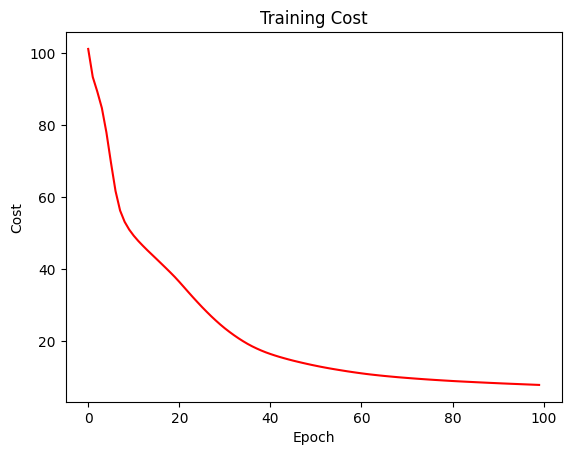

In [19]:
epochs_2 = 100

learningRate_2 = 0.00001

#----------------------------------------

sb = SonarBrain(len(X_2[0]), 64, 64, len(Y_2[0]))

print(sb)

#----------------------------------------

losses = []

# Take binary cross entropy as loss function (one output interpreted as binary)
lossFunction_2 = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent_2 = torch.optim.SGD(sb.parameters(), lr=learningRate_2)

#----------------------------------------

for j in tqdm(range(epochs_2)):

    losses_epoch = []
    for x, y in zip(X_2, Y_2):
    
        # Reset the gradient delta's (dw, db)
        gradientDescent_2.zero_grad()

        # Forward step
        yhat = sb(x)

        # Compute loss
        loss = lossFunction_2(yhat, y)
        
        # Keep track of loss
        losses_epoch.append(loss.item())

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent_2.step()

    losses.append(sum(losses_epoch)/len(losses_epoch))

print(losses)

#----------------------------------------

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(len(losses))], losses, 'red')
plt.show()

#----------------------------------------

In [20]:
save_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/pickle/SonarBrain.pkl"

pickle.dump(sb.sb_model, open(save_path, 'wb'))